# Trajectory smoothing

<img align="right" src="https://anitagraser.github.io/movingpandas/pics/movingpandas.png">

This tutorial covers trajectory smoothing using a Kalman Smoother with a Constant Velocity model. 

Trajectory smoothing can be used to correct jittery/noisy trajectories.

## Jupyter notebook setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import timedelta
from geopandas import GeoDataFrame, read_file
from fiona.crs import from_epsg
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
import movingpandas as mpd
import warnings
warnings.simplefilter("ignore")

## Loading trajectory data from GeoPackage

The MovingPandas repository contains a demo GeoPackage file that can be loaded as follows:

In [3]:
df = read_file('data\demodata_geolife.gpkg')
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t').tz_localize(None)
print("Finished reading {} rows".format(len(df)))

Finished reading 5908 rows


## Create original trajectories

Let's create the trajectories

In [4]:
traj_collection = mpd.TrajectoryCollection(df, 'trajectory_id')
print(traj_collection)

TrajectoryCollection with 5 trajectories


<AxesSubplot:>

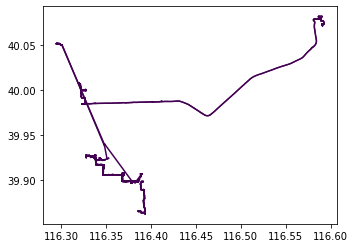

In [5]:
traj_collection.plot(column='trajectory_id', width=5, capstyle='round')

## Split trajectories

From the plot above, we can observe jumps in some trajectories. This is caused due to missing data. To aleviate this problem, we can use an ``ObservationGapSplitter`` in order to split trajectories that exhibit time gaps greater than 10 minutes  

In [6]:
split = mpd.ObservationGapSplitter(traj_collection).split(gap=timedelta(minutes=15))
print(split)

TrajectoryCollection with 11 trajectories


Text(0.5, 1.0, 'Split Trajectories')

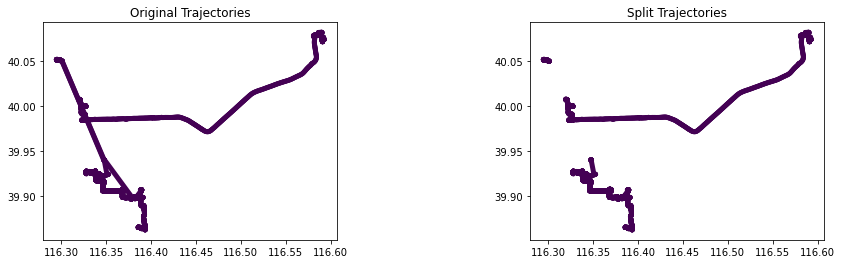

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
traj_collection.plot(ax=axes[0], column='trajectory_id', linewidth=5, capstyle='round')
axes[0].set_title('Original Trajectories')
split.plot(ax=axes[1], column='trajectory_id', linewidth=5, capstyle='round')
axes[1].set_title('Split Trajectories')

Great, we can see now that jumps have been eliminated.

## Smooth trajectories

We use the `KalmanSmootherCV` trajectory smoother to smooth all trajectories based on the assumption of a **nearly-constant velocity (CV) model**. The `process_noise_std` and `measurement_noise_std` parameters can be used to tune smoother:
- `process_noise_std` governs the uncertainty associated with the adherence of the new (smooth) trajectories to the CV model assumption; higher values relax the assumption, therefore leading to less-smooth trajectories, and vice-versa. 
- `measurement_noise_std` controls the assumed error in the original trajectories; higher values dictate that the original trajectories are expected to be noisier (and therefore, less reliable), thus leading to smoother trajectories, and vice-versa.  

You are encouraged to experiment with different tuning parameters and then observe the resulting trajectories.

In [8]:
smooth = mpd.KalmanSmootherCV(split).smooth(process_noise_std=0.1, measurement_noise_std=10)
print(smooth)

TrajectoryCollection with 11 trajectories


Let's visually compare the smooth and original (split) trajectories. 

In [9]:
(split.hvplot(title='Original Trajectories', line_width=2, tiles='StamenTonerBackground', frame_height=400, frame_width=400) + 
 smooth.hvplot(title='Smooth Trajectories', line_width=2, tiles='StamenTonerBackground', frame_height=400, frame_width=400))

:Layout
   .Overlay.I  :Overlay
      .Tiles.I   :Tiles   [x,y]
      .Path.I    :Path   [Longitude,Latitude]
      .Path.II   :Path   [Longitude,Latitude]
      .Path.III  :Path   [Longitude,Latitude]
      .Path.IV   :Path   [Longitude,Latitude]
      .Path.V    :Path   [Longitude,Latitude]
      .Path.VI   :Path   [Longitude,Latitude]
      .Path.VII  :Path   [Longitude,Latitude]
      .Path.VIII :Path   [Longitude,Latitude]
      .Path.IX   :Path   [Longitude,Latitude]
      .Path.X    :Path   [Longitude,Latitude]
      .Path.XI   :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .Tiles.I   :Tiles   [x,y]
      .Path.I    :Path   [Longitude,Latitude]
      .Path.II   :Path   [Longitude,Latitude]
      .Path.III  :Path   [Longitude,Latitude]
      .Path.IV   :Path   [Longitude,Latitude]
      .Path.V    :Path   [Longitude,Latitude]
      .Path.VI   :Path   [Longitude,Latitude]
      .Path.VII  :Path   [Longitude,Latitude]
      .Path.VIII :Path   [Longitude,Latitude]
      .Path.IX   :Path   [Longitude,Latitude]
      .Path.X    :Path   [Longitude,Latitude]
      .Path.XI   :Path   [Longitude,Latitude]

And finally, let's observe the speed calculated for the two sets of trajectories.

Text(0.5, 1.0, 'Smooth Trajectories')

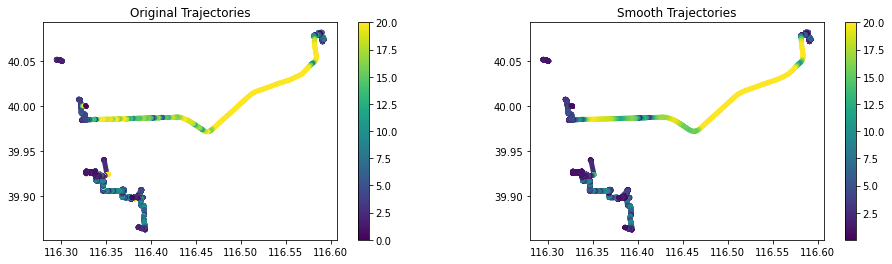

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
split.plot(ax=axes[0], column='speed', linewidth=5, capstyle='round', legend=True, vmax=20)
axes[0].set_title('Original Trajectories')
smooth.plot(ax=axes[1], column='speed', linewidth=5, capstyle='round', legend=True, vmax=20)
axes[1].set_title('Smooth Trajectories')

As expected, the smooth trajectories are significantly less rugged (i.e. noisy) and exhibit smoother velocity transitions.